In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mtd
import os
import pickle
from calendar import monthrange
import datetime
from sklearn.metrics import mean_squared_error

import matplotlib.colors as colors
from datetime import datetime, timedelta
import os                                  # Used to convert png to other format
import rpnpy.librmn.all as rmn             # Module to read RPN files
from rpnpy.rpndate import RPNDate, RPNDateRange
from fstd2nc.mixins.dates import stamp2datetime

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units

%matplotlib inline
plt.style.use('seaborn-ticks')

In [5]:
# Questions:
# Is there any wind data in the sounding?

'/instruments/SAJESS/MustTrailer/soundings/2021_04/master/SAJESS_SOUNDING_20210421_17/SAJESS_SOUNDING_20210421_17.dat'

In [15]:
f = '/instruments/SAJESS/MustTrailer/soundings/2021_04/master'
ff = 'SAJESS_SOUNDING_20210422_02'
path = f'SAJESS_SOUNDING_20210421_17.dat'
path = f'{f}/{ff}/SAJESS_SOUNDING_20210422_02_TSPOTINT.txt'
# SAJESS_SOUNDING_20210421_17
# SAJESS_SOUNDING_20210421_20
# SAJESS_SOUNDING_20210421_20-1
# SAJESS_SOUNDING_20210421_23
df = pd.read_csv(path, header=0, index_col=False,parse_dates=[0], infer_datetime_format=True, 
                 na_values=['999999999.000','9999999999'])#, 
#aux = df.drop(columns=['Fl Sec', 'Az', 'El', 'Az Tr Offs', 'El Tr Offs', 'Sys V', 'Sys I', 'Az I', 'El I', 'MCU Stat', 'SCA Stat', 'SAA BIT', 'MCU BIT', 'SCA BIT', 'CDU1 BIT', 'CDU2 BIT'])
#aux = aux.dropna(thresh=12)

In [16]:
df.columns

Index(['       UTC_Date       UTC_Time        FltTime         Ascent        GPM_AGL        GPM_MSL        Alt_AGL        Alt_MSL          Press           Temp         RelHum        Mix_Rat             DP         WSpeed          WDirn'], dtype='object')

In [172]:
'''
1) Get the date of the soundings file
2) Open the model file. Get the levels
3) Get the vars (TT, GZ, HU, HR, UU, VV, Pressure). 
4) Sort the levels
5) For each lat/lon/height in the soundings file, get the relative point in the model
6) Plot the skew-P graph
'''
f_hrdps = '/chinook/cruman/Data/HRDPS_SAJESS'
y = 2021
m = 4
d = 19
hour=18
typ = 'model'
filename_1 = f"{f_hrdps}/{typ}/{y}{m:02d}{d:02d}{hour:02d}_047_zoom" 
filename_2 = f"{f_hrdps}/{typ}/{y}{m:02d}{d:02d}{hour:02d}_048_zoom" 

dt = datetime(y, m, d, hour) + timedelta(hours=47)

# The only soundings that match the model data that I have is for the 2021-04-21 17h00
# 1
f = '/instruments/SAJESS/MustTrailer/soundings/2021_04/master'
path = f'SAJESS_SOUNDING_20210421_17.dat'
# SAJESS_SOUNDING_20210421_17
# SAJESS_SOUNDING_20210421_20
# SAJESS_SOUNDING_20210421_20-1
# SAJESS_SOUNDING_20210421_23
df = pd.read_csv(path, header=0, index_col=False,parse_dates=[0], infer_datetime_format=True, 
                 na_values=['999999999.000','9999999999'])#, 
                #usecols=['Date+Time', 'DateTime', 'Press', 'TAir', 'THum', 'Hum', 'Lat', 'Long', 'Alt'])
aux = df.drop(columns=['Fl Sec', 'Az', 'El', 'Az Tr Offs', 'El Tr Offs', 'Sys V', 'Sys I', 'Az I', 'El I', 'MCU Stat', 'SCA Stat', 'SAA BIT', 'MCU BIT', 'SCA BIT', 'CDU1 BIT', 'CDU2 BIT'])
aux = aux.dropna(thresh=12)
aux['Timestamp'] = pd.to_datetime(aux['Date+Time'])
df = aux[aux['Timestamp'] > datetime(2021, 4, 21, 17,0)]

# 2 and 3 and 4
data_TT, dates, height_TT = readVerticalRecords("TT", RPNDate(dt), filename_1)
data_GZ, dates, height_GZ = readVerticalRecords("GZ", RPNDate(dt), filename_1)
data_HU, dates, height_HU = readVerticalRecords("HU", RPNDate(dt), filename_1)
data_PX, dates, height_PX = readVerticalRecords("PX", RPNDate(dt), filename_1)
data_HR, dates, height_HR = readVerticalRecords("HR", RPNDate(dt), filename_1)
data_UU, dates, height_UU = readVerticalRecords("UU", RPNDate(dt), filename_1)
data_VV, dates, height_VV = readVerticalRecords("VV", RPNDate(dt), filename_1)

# 5
lats2d, lons2d = getLatLon(filename_1, 'TT')
#i, j = geo_idx([lat,lon], np.array([lat2d,lon2d]))
# For each line in the df dataframe, get the lat lon Alt and get the equivalent value in the model.
alt_0 = df.iloc[0]['Alt']

aux1 = []
aux2 = []
height_1 = data_GZ[0::2] # Wind
height_2 = data_GZ[1::2] # Others
pressure_1 = data_PX[0::2] # Wind
pressure_2 = data_PX[1::2] # Others
check = True
for index, row in df.iterrows():
    lat = row['Lat']
    lon = row['Long']
    alt = row['Alt'] - alt_0
    # if time is greater than 30min, reload the data with the new file
    if row['Timestamp'].hour == 17 and row['Timestamp'].minute > 30 and check:
        check = False
        dt = datetime(y, m, d, hour) + timedelta(hours=48)
        data_TT, dates, height_TT = readVerticalRecords("TT", RPNDate(dt), filename_2)
        data_GZ, dates, height_GZ = readVerticalRecords("GZ", RPNDate(dt), filename_2)
        data_HU, dates, height_HU = readVerticalRecords("HU", RPNDate(dt), filename_2)
        data_PX, dates, height_PX = readVerticalRecords("PX", RPNDate(dt), filename_2)
        data_HR, dates, height_HR = readVerticalRecords("HR", RPNDate(dt), filename_2)
        data_UU, dates, height_UU = readVerticalRecords("UU", RPNDate(dt), filename_2)
        data_VV, dates, height_VV = readVerticalRecords("VV", RPNDate(dt), filename_2)
        height_1 = data_GZ[0::2] # Wind
        height_2 = data_GZ[1::2] # Others
        pressure_1 = data_PX[0::2] # Wind
        pressure_2 = data_PX[1::2] # Others
        
    i, j = geo_idx([lat,lon], np.array([lats2d,lons2d]))
    z1 = np.abs(height_1[:,i,j] - alt).argmin()
    z2 = np.abs(height_2[:,i,j] - alt).argmin()    
    aux1.append([row['Timestamp'], height_1[z1,i,j], data_TT[z1,i,j], data_HU[z1,i,j], pressure_1[z1,i,j], data_HR[z1,i,j]])
    aux2.append([row['Timestamp'], height_2[z2,i,j], pressure_2[z2,i,j], data_UU[z2,i,j], data_VV[z2,i,j]])

df_model1 = pd.DataFrame(aux1, columns=['Timestamp','GZ_1', 'TT', 'HU', 'PX_1', 'HR'])
df_model2 = pd.DataFrame(aux2, columns=['Timestamp','GZ_2', 'PX_2', 'UU', 'VV'])

aux1 = df_model1.drop(columns=['Timestamp'])
test1 = aux1.drop_duplicates()

aux2 = df_model2.drop(columns=['Timestamp'])
test2 = aux2.drop_duplicates()

In [147]:
df.head()

,Number,Date+Time,DateTime,Press,TAir,THum,Hum,Lat,Long,Alt,Freq,RSSI,F Offs,Rx Stat,POST,Rx BIT,State,Flags,Timestamp
1662,1537,2021-04-21 17:00:01,44307.708351,991.06,3.29,3.85,81.0,47.361553,-68.320702,145.0,401.995,-51.0,-150.0,12.0,0.0,0.0,4,2098953,2021-04-21 17:00:01
1663,1538,2021-04-21 17:00:02,44307.708362,991.07,3.33,3.82,81.3,47.361557,-68.320702,145.0,401.996,-52.0,100.0,12.0,0.0,0.0,4,2098953,2021-04-21 17:00:02
1664,1539,2021-04-21 17:00:03,44307.708374,991.07,3.35,3.82,81.2,47.361557,-68.320702,145.0,401.996,-52.0,95.0,12.0,0.0,0.0,4,2098953,2021-04-21 17:00:03
1665,1540,2021-04-21 17:00:04,44307.708385,991.06,3.36,3.80,81.0,47.361553,-68.320702,145.0,401.995,-52.0,75.0,12.0,0.0,0.0,4,2098953,2021-04-21 17:00:04
1666,1541,2021-04-21 17:00:05,44307.708397,991.06,3.32,3.78,80.9,47.361553,-68.320702,145.0,401.995,-52.0,-425.0,12.0,0.0,0.0,4,2098953,2021-04-21 17:00:05


In [157]:
# interpolate the model data to the levels of the sounding
#new_TT = interpPressure(test1['PX_1'].values, p.m[62:4000:5], test1['TT'].values, interp='linear') * units.degC
#new_P1 = p.m[62:4000:5] * units.hPa
#new_P2 = p.m[68:4000:5] * units.hPa
#new_HR = interpPressure(test1['PX_1'].values, p.m[62:4000:5], test1['HR'].values, interp='linear') * units('%')
#new_UU = interpPressure(test2['PX_2'].values, p.m[68:4000:5], test2['UU'].values, interp='linear') * units.meters / units.second
#new_VV = interpPressure(test2['PX_2'].values, p.m[68:4000:5], test2['VV'].values, interp='linear') * units.meters / units.second
#new_Td = mpcalc.dewpoint_from_relative_humidity(new_TT, new_HR)

#p = df['Press'].values * units.hPa
#T = df['TAir'].values * units.degC
#Td = df['THum'].values * units.degC

In [173]:
p = df['Press'].values * units.hPa
T = df['TAir'].values * units.degC
Td = df['THum'].values * units.degC
HR = df['Hum'].values * units('%')
Td2 = mpcalc.dewpoint_from_relative_humidity(T, HR)
#wind_speed = df['speed'].values * units.knots
#wind_dir = df['direction'].values * units.degrees
#u, v = mpcalc.wind_components(wind_speed, wind_dir)
p1_model = test1['PX_1'].values[:40] * units.hPa
p2_model = test2['PX_2'].values[:40] * units.hPa
T_model = test1['TT'].values[:40] * units.degC
HR_model = test1['HR'].values[:40]*100 * units('%')
Td_model = mpcalc.dewpoint_from_relative_humidity(T_model, HR_model)
u_model = test2['UU'].values[:40] * units.meters / units.second
v_model = test2['VV'].values[:40] * units.meters / units.second

999.6546811699848 hectopascal 3.972844974953366 degree_Celsius


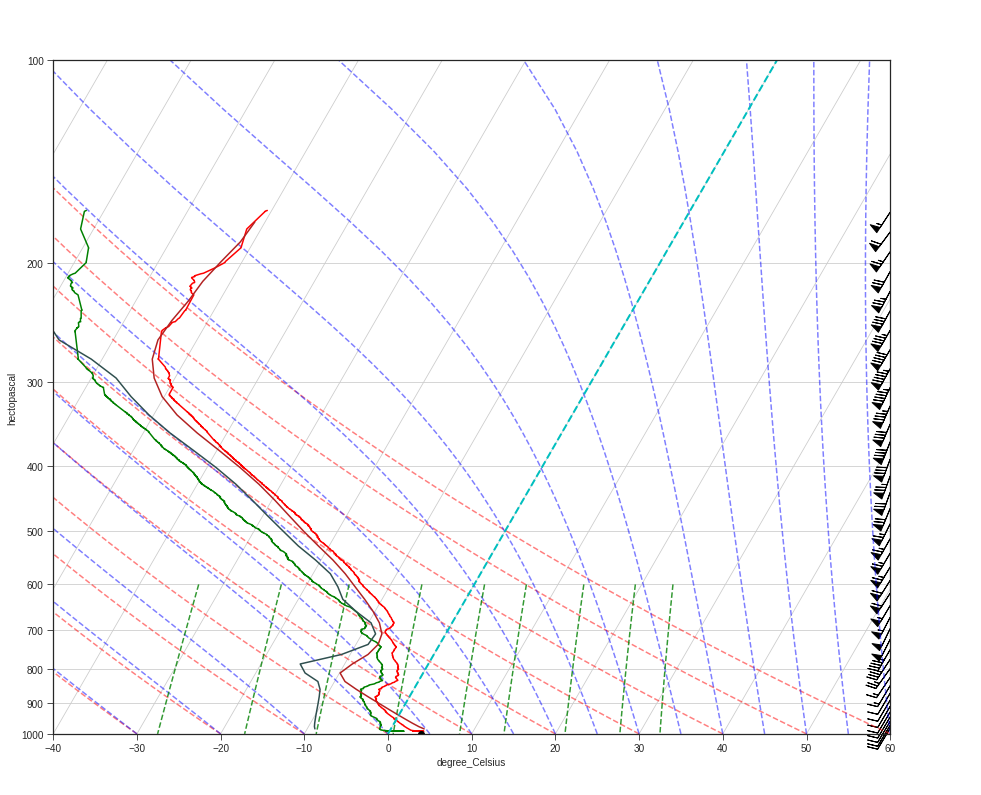

In [174]:
# Calculate the LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

print(lcl_pressure, lcl_temperature)

# Calculate the parcel profile.
#parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(15, 15))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r', label='Obs')
skew.plot(p, Td2, 'g', label='Obs')

skew.plot(p1_model, T_model, 'firebrick', label='Model')
skew.plot(p1_model, Td_model, 'darkslategray', label='Model')

skew.plot_barbs(p2_model, u_model, v_model)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
#skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
#skew.shade_cin(p, T, parcel_prof, Td)
#skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.show()

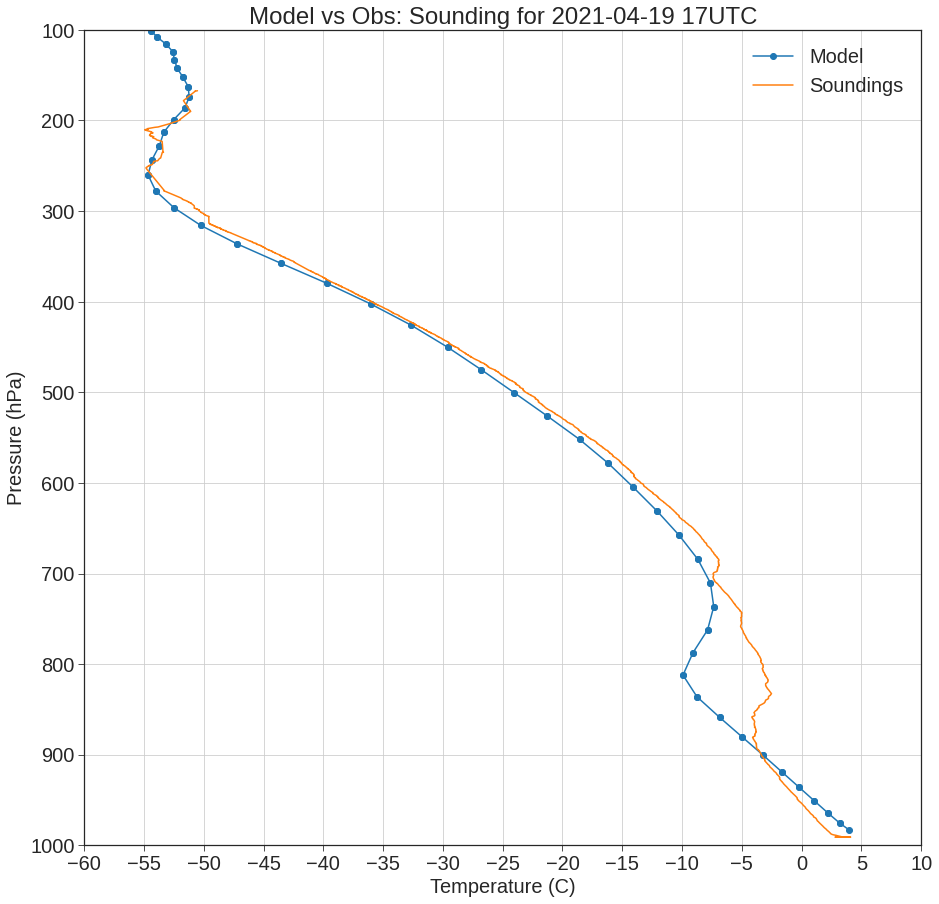

In [164]:
fig = plt.figure(figsize=(15, 15))
plt.plot(test.TT, test.PX_1, marker='o', label='Model')
plt.plot(df.TAir, df.Press, label='Soundings' )
plt.gca().invert_yaxis()
plt.legend(fontsize=20)
plt.ylim(1000, 100)
plt.xticks(np.arange(-60,11,5), fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Pressure (hPa)', fontsize=20)
plt.xlabel('Temperature (C)', fontsize=20)
plt.grid(True)
plt.title('Model vs Obs: Sounding for 2021-04-19 17UTC', fontsize=24)
plt.savefig('model_obs_TT.png')

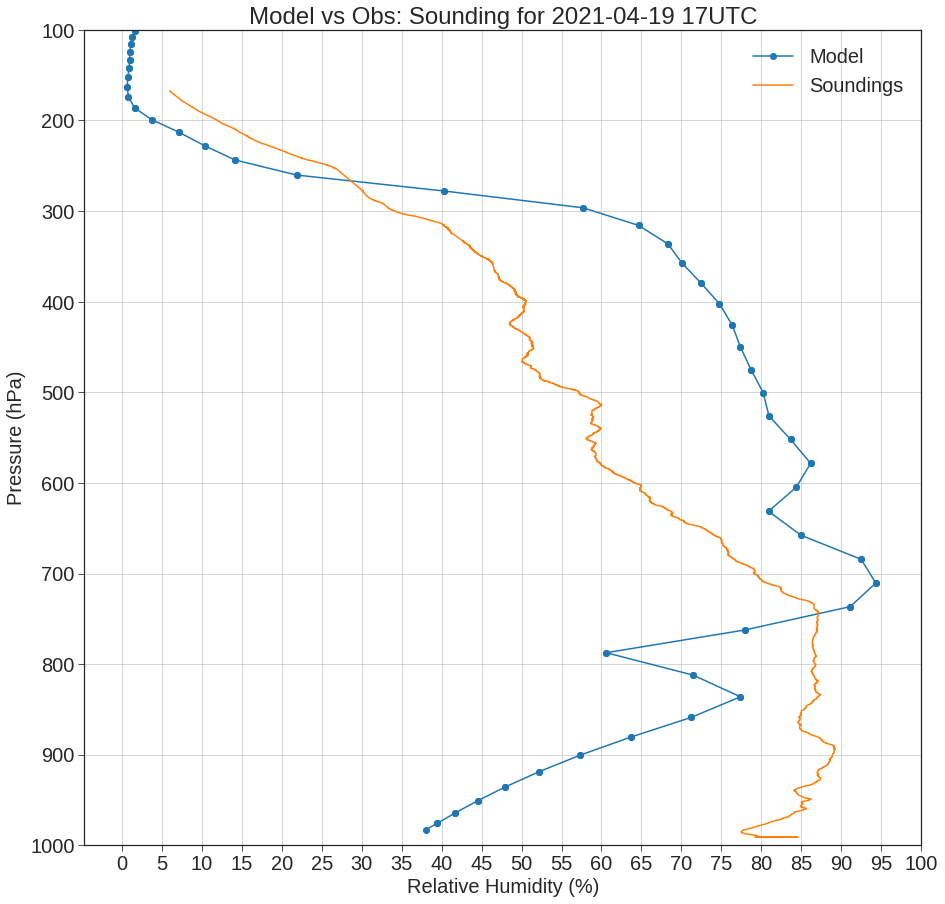

In [160]:
fig = plt.figure(figsize=(15, 15))
plt.plot(test.HR*100, test.PX_1, marker='o', label='Model')
plt.plot(df.Hum, df.Press, label='Soundings' )
plt.gca().invert_yaxis()
plt.legend(fontsize=20)
plt.ylim(1000, 100)
plt.xticks(np.arange(0,101,5), fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Pressure (hPa)', fontsize=20)
plt.xlabel('Relative Humidity (%)', fontsize=20)
plt.grid(True)
plt.title('Model vs Obs: Sounding for 2021-04-19 17UTC', fontsize=24)
plt.savefig('model_obs_HR.png')

In [87]:
def interpPressure(pressure, pressure_levels, data, interp='linear'):
  """
  Interpolate data to custom pressure levels
  pressure: Original pressure level
  pressure_levels: Custom pressure level
  data: Original variable to be interpolated to custom pressure level
  returns: new_val, the original variable interpolated.
  """
  from scipy import interpolate

  f = interpolate.interp1d(pressure, data, kind=interp)
  
  new_val = f(pressure_levels)

  return new_val

def geo_idx(dd, dd_array, type="lat"):
  '''
    search for nearest decimal degree in an array of decimal degrees and return the index.
    np.argmin returns the indices of minium value along an axis.
    so subtract dd from all values in dd_array, take absolute value and find index of minimum.
    
    Differentiate between 2-D and 1-D lat/lon arrays.
    for 2-D arrays, should receive values in this format: dd=[lat, lon], dd_array=[lats2d,lons2d]
  '''
  if type == "lon" and len(dd_array.shape) == 1:
    dd_array = np.where(dd_array <= 180, dd_array, dd_array - 360)

  if (len(dd_array.shape) < 2):
    geo_idx = (np.abs(dd_array - dd)).argmin()
  else:
    if (dd_array[1] < 0).any():
      dd_array[1] = np.where(dd_array[1] <= 180, dd_array[1], dd_array[1] - 360)

    a = abs( dd_array[0]-dd[0] ) + abs(  np.where(dd_array[1] <= 180, dd_array[1], dd_array[1] - 360) - dd[1] )
    i,j = np.unravel_index(a.argmin(), a.shape)
    geo_idx = [i,j]

  return geo_idx

def readVerticalRecords(varname, datev, filename):
    fid = rmn.fstopenall(filename,rmn.FST_RO)
    
    record_list = []
    record_date_list = []
    #record_ip = []
    record_ip1 = []
    record_ip1_type = []
    
    for k in rmn.fstinl(fid, nomvar=varname, datev=datev.datev):
        #print(rmn.fstluk(k))
        record_list.append(rmn.fstluk(k)['d'])                
        record_date_list.append(stamp2datetime(rmn.fstluk(k)['datev']))
        ip1=rmn.fstluk(k)['ip1']
        ip2=rmn.fstluk(k)['ip2']
        ip3=rmn.fstluk(k)['ip3']
        rp1, rp2, rp3 = rmn.DecodeIp(ip1, ip2, ip3)    
        #record_ip.append([(rp1.v1, rmn.kindToString(rp1.kind)), (rp2.v1, rmn.kindToString(rp2.kind)), (rp3.v1, rmn.kindToString(rp3.kind))])
        record_ip1.append(rp1.v1)
        record_ip1_type.append(rmn.kindToString(rp1.kind))            
        
    #print(record_date_list)
    
    r_data = np.array(record_list)    
    r_date = np.array(record_date_list)
    r_height = np.array(record_ip1)    
    
    # Sort by height
    idx = np.argsort(r_height)
    r_data = r_data[idx][::-1]
    r_date = r_date[idx][::-1]
    r_height = r_height[idx][::-1]    

    # Dropping the first level. I only want the model levels
    return r_data[1:], r_date[1:], r_height[1:]

def getLatLon(filename, var):
    fid = rmn.fstopenall(filename,rmn.FST_RO)   # Open the file    
    rec = rmn.fstlir(fid,nomvar=var)        # Read the full record of variable 'varname'
    field = rec['d']#[i1:i2,j1:j2]                            # Assign 'field' to the data of 'varname' 
    mygrid = rmn.readGrid(fid,rec)              # Get the grid information for the (LAM) Grid -- Reads the tictac's
    latlondict = rmn.gdll(mygrid)               # Create 2-D lat and lon fields from the grid information

    lat2d = latlondict['lat']#[i1:i2,j1:j2]                     # Assign 'lat' to 2-D latitude field
    lon2d = latlondict['lon']#[i1:i2,j1:j2]                    # Assign 'lon' to 2-D longitude field
    
    return lat2d, lon2d

In [ ]:
# Observations
# /instruments/SAJESS/MustTrailer/observations/2021_04/master/SJ_MT_OBS_202104.csv

In [ ]:
# Another Wind data, for the trailer
# /instruments/SAJESS/MustTrailer/mast/2021_04/master/SJ_MT_MAST_01_MAS_1min_202104.txt